# GD6. Class Activation Map 만들기

## CAM, Grad-CAM용 모델 준비하기 (1) 데이터셋 준비하기

- CAM(Class Activation Map)은 특성을 추출하는 CNN 네트워크 뒤에 GAP(Global Average Pooling)과 소프트맥스 레이어가 붙는 형태로 구성되어야 한다는 제약이 있음. 
- 반면 Grad-CAM은 이러한 제약이 없음.
- CAM을 위한 모델을 먼저 구성해 기본적인 CAM을 추출해보고, 이 모델에서 Grad-CAM을 활용해 다시 시각화 결과물을 추출해보자. 
- Grad-CAM은 모델의 구조에 제약이 없기 때문에 CAM에만 모델을 맞춰도 충분하다고 함. 
- CAM은 클래스에 대한 활성화 정도를 나타낸 지도임. 따라서 기본적으로 분류를 수행하는 모델이어야 하고 이미지 내에서 클래스가 활성화된 위치를 확인하고 이를 정답과 비교하는 것이므로 위치 정보가 기록된 데이터가 함께 있어야 함. 
- 여기서는 `stanford_dogs` 데이터셋을 사용함. 
- 120종의 개를 사진으로 판별하는 분류 문제 데이터셋으로, 라벨이 위치 정보인 바운딩 박스 정보를 포함함. 

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

- 12000장의 학습용 데이터셋과 8580장의 평가용 데이터셋으로 구성됨.

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteXN29SH/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteXN29SH/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


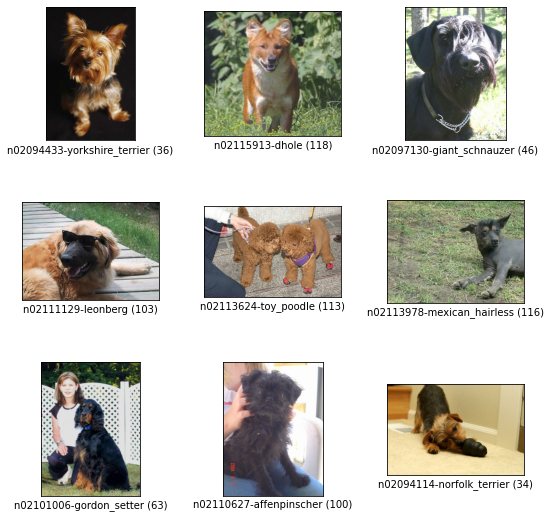

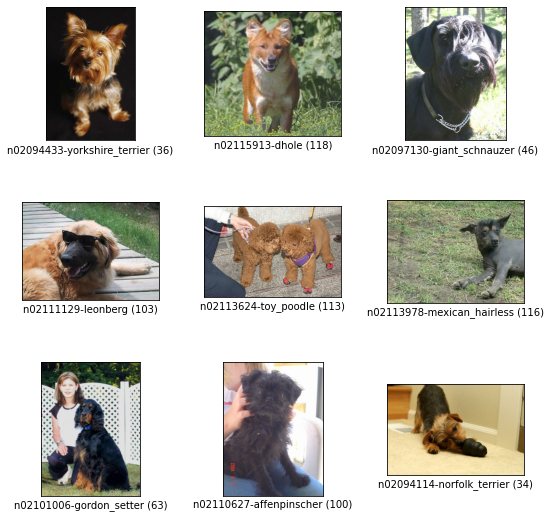

In [4]:
tfds.show_examples(ds_train, ds_info)

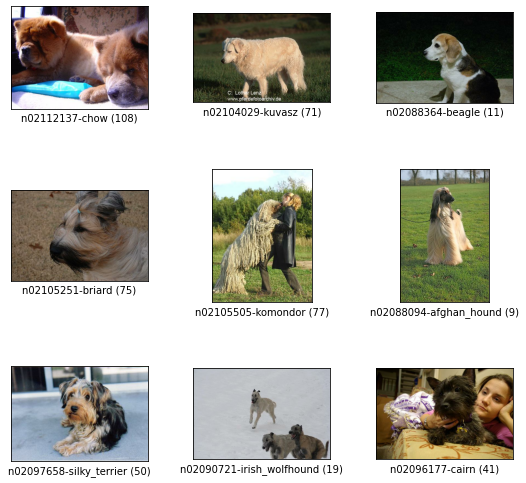

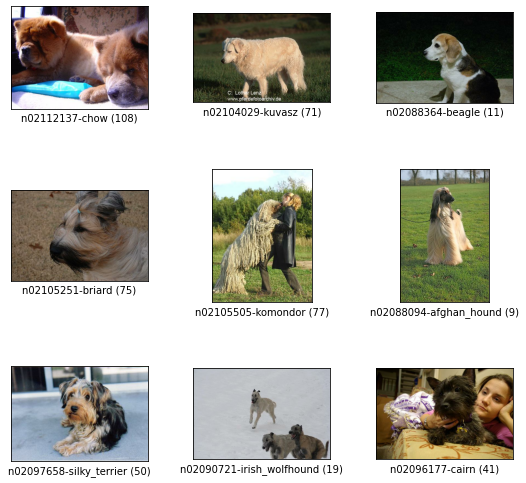

In [5]:
tfds.show_examples(ds_test, ds_info)

## CAM, Grad-CAM용 모델 준비하기 (2) 물체의 위치정보
- 원본 이미지 위에 물체의 위치정보는 어떻게 시각화해 표시할 수 있을까?
- 데이터셋의 메타 정보인 `ds_info`를 조회해 `features`가 어떻게 구성되어 있는지 확인해보자. 

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

- `bbox`는 물체의 위치를 사각형 영역으로 표기하는 방법으로, `BBoxFeature`라는 타입으로 정의됨.

### 바운딩 박스를 표시하는 방법들
- 'xywh'는 바운딩박스 중심점을 x, y로 표기하고, 사각형의 너비 w와 높이 h를 표기하는 방법임. 
  - (예) `(x_center, y_center, width, height)`
  - x, y가 중심점이 아니라 좌측 상단의 점을 가리킬 수도 있음.
- 'minmax'는 바운딩박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법임. 
  - (예) `(x_min, x_max, y_min, y_max)`
  - 좌표의 절대값이 아니라, 전체 이미지의 너비와 높이를 기준으로 normalize한 상대적인 값을 표기하는 것이 일반적임. 
- 위 두 가지 말고도 LRTB, QUAD 등 다양한 표기법이 존재함. 

## CAM, Grad-CAM용 모델 준비하기 (3) CAM을 위한 모델 만들기
- 미리 이미지넷 데이터에 훈련된 ResNet50을 기반으로 하고, 이후 pooling layer 뒤에 소프트맥스 레이어를 붙여 Grad-CAM 모델을 만듦.
- 참고로 소프트맥스 레이어는 소프트맥스 함수를 활성화 함수로 사용하는 fc 레이어임. 
- ResNet50 뒤에 필요한 레이어를 붙여 CAM을 구하기 위한 기본 모델을 완성해보자. 

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 1s 0us/step


- CAM 모델은 일반적인 분류 모델과 크게 다른 점이 없음. 
- 다만 마지막 fc 레이어 대신 GAP을 사용해야 함.
- ResNet50의 매개변수 pooling에 avg를 매개변수로 전달해 쉽게 GAP 연산을 붙일 수 있음. 

In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## CAM, Grad-CAM용 모델 준비하기 (4) CAM 모델 학습하기
- `input`에 `bbox` 정보가 포함되어 있지만, CAM 모델의 학습에 필요가 없기에 전처리에서 제외함. 
- CAM 모델은 object detection이나 segmentation에도 활용될 수 있지만, bouding box 같은 직접적인 라벨을 사용하지 않고 weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방법이기 때문임. 

In [9]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
# 데이터셋에 전처리와 배치처리를 적용 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [12]:
'''
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)
'''

"\nhistory_cam_model = cam_model.fit(\n    ds_train_norm,\n    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),\n    validation_steps=int(ds_info.splits['test'].num_examples/16),\n    epochs=2,\n    validation_data=ds_test_norm,\n    verbose=1,\n    use_multiprocessing=True,\n)\n"

## CAM

In [13]:
'''
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds
'''

"\n# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행\nimport tensorflow as tf\nfrom tensorflow import keras\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport tensorflow_datasets as tfds\nimport copy\nimport cv2\nfrom PIL import Image\n\n(ds_train, ds_test), ds_info = tfds.load(\n    'stanford_dogs',\n    split=['train', 'test'],\n    shuffle_files=True,\n    with_info=True,\n)\n\ndef normalize_and_resize_img(input):\n    # Normalizes images: `uint8` -> `float32`\n    image = tf.image.resize(input['image'], [224, 224])\n    input['image'] = tf.cast(image, tf.float32) / 255.\n    return input['image'], input['label']\n\ndef apply_normalize_on_dataset(ds, is_test=False, batch_size=16):\n    ds = ds.map(\n        normalize_and_resize_img, \n        num_parallel_calls=2\n    )\n    ds = ds.batch(batch_size)\n    if not is_test:\n        ds = ds.repeat()\n        ds = ds.shuffle(200)\n    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)\n    return ds\n"

- CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 단위로 이루어지기에 `get_one()` 함수로 데이터셋에서 한 장씩 뽑을 수 있게 함. 

In [14]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

108


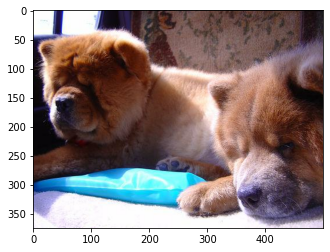

In [15]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

- 데이터가 준비되었으니 CAM을 생성하기위해 미리 준비된 학습한 모델을 불러오자. 

In [16]:
import os
cam_model_path = '/content/drive/MyDrive/Colab Notebooks/AIFFEL/Going Deeper/GD6/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

- CAM을 생성하기 위해서는 (1) 특성 맵, (2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치, (3) 원하는 클래스의 출력값이 필요함. 
- 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 시각화해야 함. 이를 고려해 `model`과 `item`을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 함.
- `generate_cam()`을 구현하기 위해 아래에서는 `conv_outputs`와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산하도록 구현함. 마지막에는 입력 이미지의 크기에 맞춰 CAM을 `resize`함. 

In [17]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있음
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옴
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize
    return cam_image

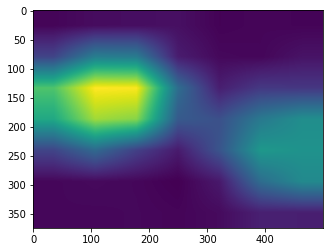

In [18]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

## Grad-CAM

67


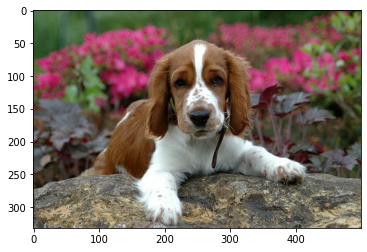

In [19]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

- `grad_cam`은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로서 관찰 대상이 되는 레이어의 채널별 가중치를 구함. 
- 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(`weight`)와 레이어에서 나온 채널별 특성 맵을 가중합해주어 `cam_image`를 얻게 됨.
- CAM 함수와 달리, Grad-CAM은 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 `activation_layer`를 뽑아서 쓸 수 있도록 `activation_layer`의 이름을 받고 이를 활용해야 함. 

In [20]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻음
        output = conv_output[0] # 원하는 layer의 output을 얻음
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻음

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구함
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻음
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

- 이제 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해보자. 
- 레이어의 이름은 `cam_model_summary()` 결과에서 찾을 수 있음.

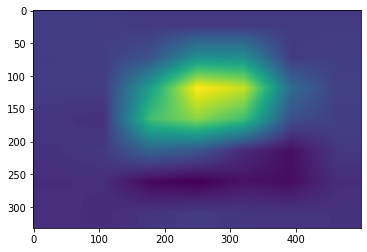

In [21]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

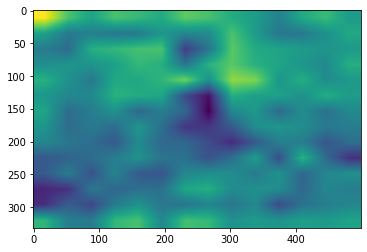

In [22]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

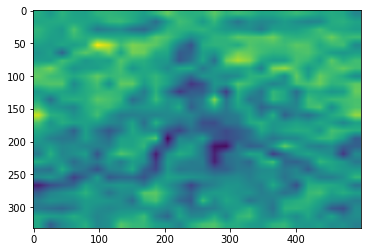

In [23]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

## Detection with CAM

### 바운딩 박스
- 이번에는 CAM에서 물체의 위치를 찾는 detection을 해보자. 
- 우선 새로운 이미지를 다시 뽑아 CAM 이미지를 뽑아보자. 

108


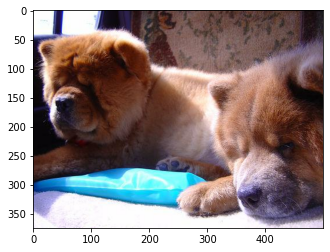

In [24]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

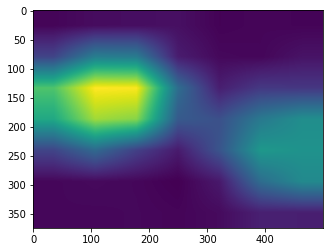

In [25]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

- `get_bbox()` 함수는 바운딩 박스를 만들기 위해서 `score_thresh`를 받아 역치값 이하의 바운딩 박스는 없앰. 그 다음 OpenCV의 `findContours()`와 `minAreaRect()`로 사각형을 찾음. 
- 이 때 `rotated_rect`라는 회전된 바운딩 박스를 얻을 수 있음. 
- `boxPoints()`로 이 꼭지점을 바꾸어주고, 마지막에는 `int` 자료형으로 변환해줌.

In [26]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

- 아래에서 `cam_image`를 통해 `bbox`를 얻고 이를 이미지 위에서 시각화한 모습을 볼 수 있음.

In [27]:
rect = get_bbox(cam_image)
rect

array([[  0, 373],
       [  0,  30],
       [498,  30],
       [498, 373]])

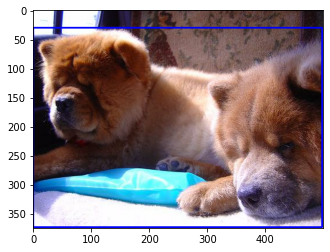

In [28]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### Intersection Over Union
- 위에서 CAM, Grad-CAM 두 가지 방법을 통해서 바운딩 박스를 얻을 수 있었음. 
- 정답 데이터인 바운딩 박스와 이를 어떻게 비교, 평가할 수 있을까?
- IoU(Intersection Over Union)은 두 영역의 교집합인 intersection 영역의 넓이를 두 영역의 합집합인 union 영역으로 나누어준 값임. 
- 이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있기에, 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 됨. 
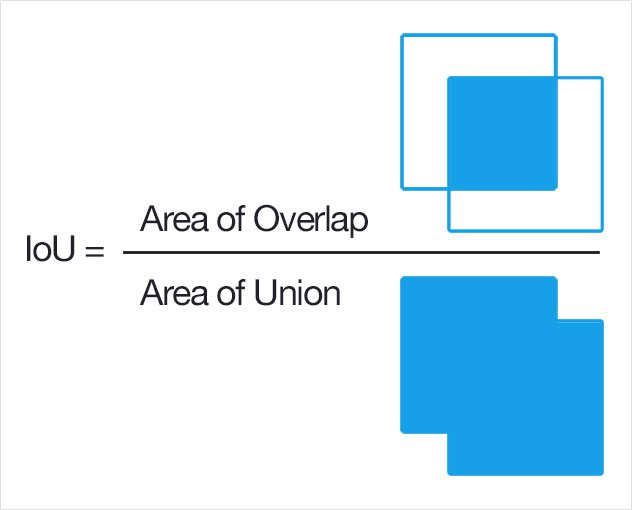

In [29]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어짐 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

- 위에서 구한 `rect`를 minmax `bbox` 형태로 치환

In [30]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.08, 0.0, 0.9946666666666667, 0.996]

- 이 데이터의 ground truth bbox 확인해보자. 

In [31]:
item['objects']['bbox']

array([[0.13066667, 0.488     , 0.96533334, 0.998     ],
       [0.072     , 0.        , 0.784     , 0.678     ]], dtype=float32)

- CAM 추론 결과로 얻어진 bbox가 ground truth와 비슷하게 얻어졌는지 IoU를 계산해서 확인해보자. 

In [32]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [33]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.46457894261807325